In [1]:
from ds11mltoolkit import data_processing

In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import pickle
from skimage.io import imread
from sklearn.utils import shuffle

## Constants

In [3]:
SEED = 42
LABELS = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
ROOT_PATH = '.'
TRAIN_PATH = ROOT_PATH + '/data/train/'
TEST_PATH = ROOT_PATH + '/data/test/'
MODELS_PATH = ROOT_PATH + '/models/'
SUBMISSIONS_PATH = ROOT_PATH + '/submissions/'

## Data Loading

In [4]:
def read_data(path, im_size):
    X = []
    ids = []

    ##### CODE #####
    # Iterar sobre todo lo que haya en path
    for file in os.listdir(path):

        # Leer la imagen a color y aplicarle el resize
        image = imread(path + file)
        smallimage = cv2.resize(image, (im_size, im_size))

        # Guardo en X
        X.append(smallimage)
        ids.append(file.replace('.jpg', ''))
        
    return np.array(X), ids

In [5]:
df, X_train, y_train = data_processing.load_imgs(TRAIN_PATH, 48)
X_test, test_ids = read_data(TEST_PATH, 48)

## Data Processing

##### Data Balancing

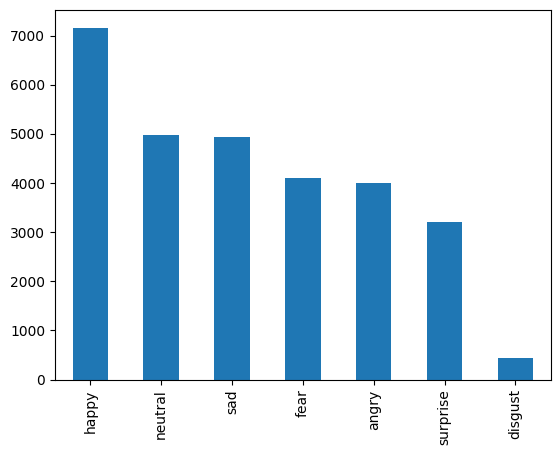

In [6]:
train_label_count = df['category'].replace(LABELS).value_counts()

train_label_count.plot.bar();

In [7]:
datagen = data_processing.ImageDataGen(
    horizontal_flip=True,
    rotation_range=20,
    shear_range=.1,
    zoom_range=.2,
    width_shift_range=.1,
    height_shift_range=.1
)

X_train = np.expand_dims(X_train, axis=-1)

X_gen, y_gen = datagen.gen_from_array(x=X_train, y=y_train, max_image_count=8000)

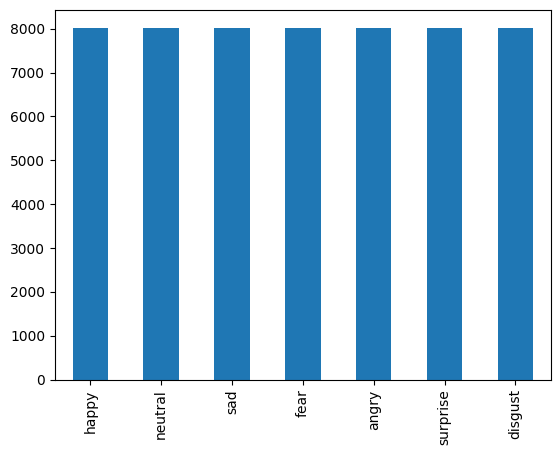

In [8]:
gen_labels, gen_label_count = np.unique(y_gen, return_counts=True)
train_label_count += np.sort(gen_label_count)

train_label_count.plot.bar();

##### Normalization

In [9]:
X_train = X_train / 255.
X_test = X_test / 255.

In [10]:
print(X_train.shape)
print(X_gen.shape)

(28821, 48, 48, 1)
(27282, 48, 48, 1)


##### Shuffle

In [11]:
X_train_gen = np.concatenate([X_train, X_gen], axis=0)
y_train_gen = np.concatenate([y_train, y_gen], axis=0)

In [12]:
X_train_gen, y_train_gen = shuffle(X_train_gen, y_train_gen, random_state=SEED)

In [13]:
print(y_train_gen.shape)
print(X_train_gen.shape)

(56103,)
(56103, 48, 48, 1)


## Data Export

In [14]:
with open(ROOT_PATH + '/data/test_ids.pkl', 'wb') as f:
    pickle.dump(test_ids, f)

np.savez(
    ROOT_PATH + '/data/data.npz',
    X_train=X_train_gen,
    X_test=X_test,
    y_train=y_train_gen
)